# Result Analysis
This notebook converts the extracted csv files produced by the experiments into dataframes and calculates central metrics on them as well as visualizing them. 

In [1]:
from typing import List
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def plot_bar(df_plot, hue=None, title=None):
    df_plot = df_plot[df_plot["task"]!="Average"].copy()

    df_plot.loc[:, 'test_score'] = df_plot.loc[:, 'test_score'] * 100
    df_plot.loc[:, 'test_score_std'] = df_plot.loc[:, 'test_score_std'] * 100

    # Create the plot
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(x='task', y='test_score', hue=hue, data=df_plot,
                    capsize=0.1, errorbar=None, palette="Set2")

    # Add error bars manually
    for i, bar in enumerate(ax.patches):
        row = df_plot.iloc[i]
        ax.errorbar(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    yerr=row['test_score_std'], color='black', capsize=3, capthick=0.5)

    # Customize the plot
    plt.title(title, fontsize=16)
    plt.xlabel('Task', fontsize=12)
    plt.ylabel('Test Score (%)', fontsize=12)
    plt.ylim(0, 100)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [3]:
def read_prompts(target_experiment: str, tasks: List[str]):
    results = pd.DataFrame()
    for logging_dir in Path(f"../logs/{target_experiment}").rglob("*.csv"):
        if "best_scores" in str(logging_dir) or not any(task in str(logging_dir) for task in tasks):
            continue

        result = pd.read_csv(logging_dir)

        logging_dir = str(logging_dir)

        logging_dir = logging_dir.replace(f"..\\logs\\{target_experiment}\\", "")
        logging_dir = logging_dir.replace(".csv", "")

        task_name, optimizer, meta_llm, evaluation_llm, random_seed = logging_dir.split("_")

        metainformation = pd.DataFrame(
            {
                "task": [task_name]*len(result),
                "optimizer": [optimizer]*len(result),
                "meta_llm": [meta_llm]*len(result),
                "evaluation_llm": [evaluation_llm]*len(result),
                "random_seed": [random_seed]*len(result),
            }
        )

        result = pd.concat([result, metainformation], axis=1)

        results = pd.concat([result, results], axis=0)

    return results

def read_best_scores(target_experiment: str):
    return pd.read_csv(f"../logs/{target_experiment}/best_scores.csv")

def get_mean_std(df):
    group_cols = ["task", "optimizer", "meta_llm", "downstream_llm", "use_task_desc"]
    df_copy = df.groupby(group_cols).agg("mean", numeric_only=True).drop(columns="random_seed")
    df_copy["test_score_std"] = df.groupby(group_cols).agg("std", numeric_only=True).drop(columns="random_seed")["test_score"]
    df_copy = df_copy.reset_index()

    return df_copy

def get_avg_across_tasks(df):
    df_avg = df.groupby(['optimizer', 'meta_llm', "downstream_llm", "use_task_desc"]).agg({
        'test_score': 'mean',
    }).reset_index()

    df_avg["task"] = "Average"

    df = pd.concat([df, df_avg], axis="index")

    return df

def clean_names(df):
    def map_task_desc(row):
        if row is None:
            return False
        if type(row) is not str:
            return False
        return  ".txt" in row
        
    llm_cols = ["meta_llm", "downstream_llm"]
    df[llm_cols] =\
        df[llm_cols]\
            .replace({c: {
                "meta-llama/Meta-Llama-3-70B-Instruct": "Llama-3-70B",
                "meta-llama\Meta-Llama-3-70B-Instruct": "Llama-3-70B",
                "meta-llama/Meta-Llama-3-8B-Instruct": "Llama-3-8B",
                "meta-llama\Meta-Llama-3-8B-Instruct": "Llama-3-8B",
                "gpt-4o-2024-05-13": "gpt-4o"
            } for c in llm_cols})

    df["optimizer"] = df["optimizer"].map({
        "evopromptde": "DE",
        "evopromptga": "GA",
        "init": "init"
    })

    df["use_task_desc"] = df["use_task_desc"].map(map_task_desc)

    return df

def format_score(df):
    df = df.copy()
    def format_score_(row):
        if pd.isna(row['test_score_std']):
            return f"{row['test_score']:.2f}"
        else:
            return f"{row['test_score']:.2f} ± {row['test_score_std']:.2f}"

    # Apply the formatting
    df['test_score'] = df.apply(lambda row: format_score_({
        'test_score': row['test_score'] * 100,
        'test_score_std': row['test_score_std'] * 100
    }), axis=1)

    # Drop the test_score_std column as it's no longer needed
    df = df.drop('test_score_std', axis=1)

    return df


def get_result_table(df):
    df = df.copy()
    return df.groupby(["meta_llm", "downstream_llm", "optimizer", "task", "use_task_desc"], as_index=False)\
        .first()\
        .pivot(index=['meta_llm', "downstream_llm", 'optimizer', "use_task_desc"], columns='task', values='test_score')

In [4]:
plt.style.use('mpl_stylesheet.mplstyle')

## Experiment (1): Llama-3-8B vs. Llama-3-70B

In [5]:
best_scores_exp = read_best_scores("experiment")
best_scores_all = get_mean_std(best_scores_exp)

bestestestes = best_scores_all.copy()

In [6]:
best_scores_init = read_best_scores("experiment-initial-prompts")
best_scores_init = best_scores_init[best_scores_init["downstream_llm"].isin(["meta-llama/Meta-Llama-3-70B-Instruct", "meta-llama/Meta-Llama-3-8B-Instruct"])]
best_scores_init[["meta_llm", "evaluation_llm", "use_task_desc", "optimizer"]] = "init"
best_scores_init = get_mean_std(best_scores_init)

best_scores_all = pd.concat([best_scores_init, best_scores_all])

In [7]:
best_scores_all = get_avg_across_tasks(best_scores_all)
best_scores_all = clean_names(best_scores_all)


IndexError: single positional indexer is out-of-bounds

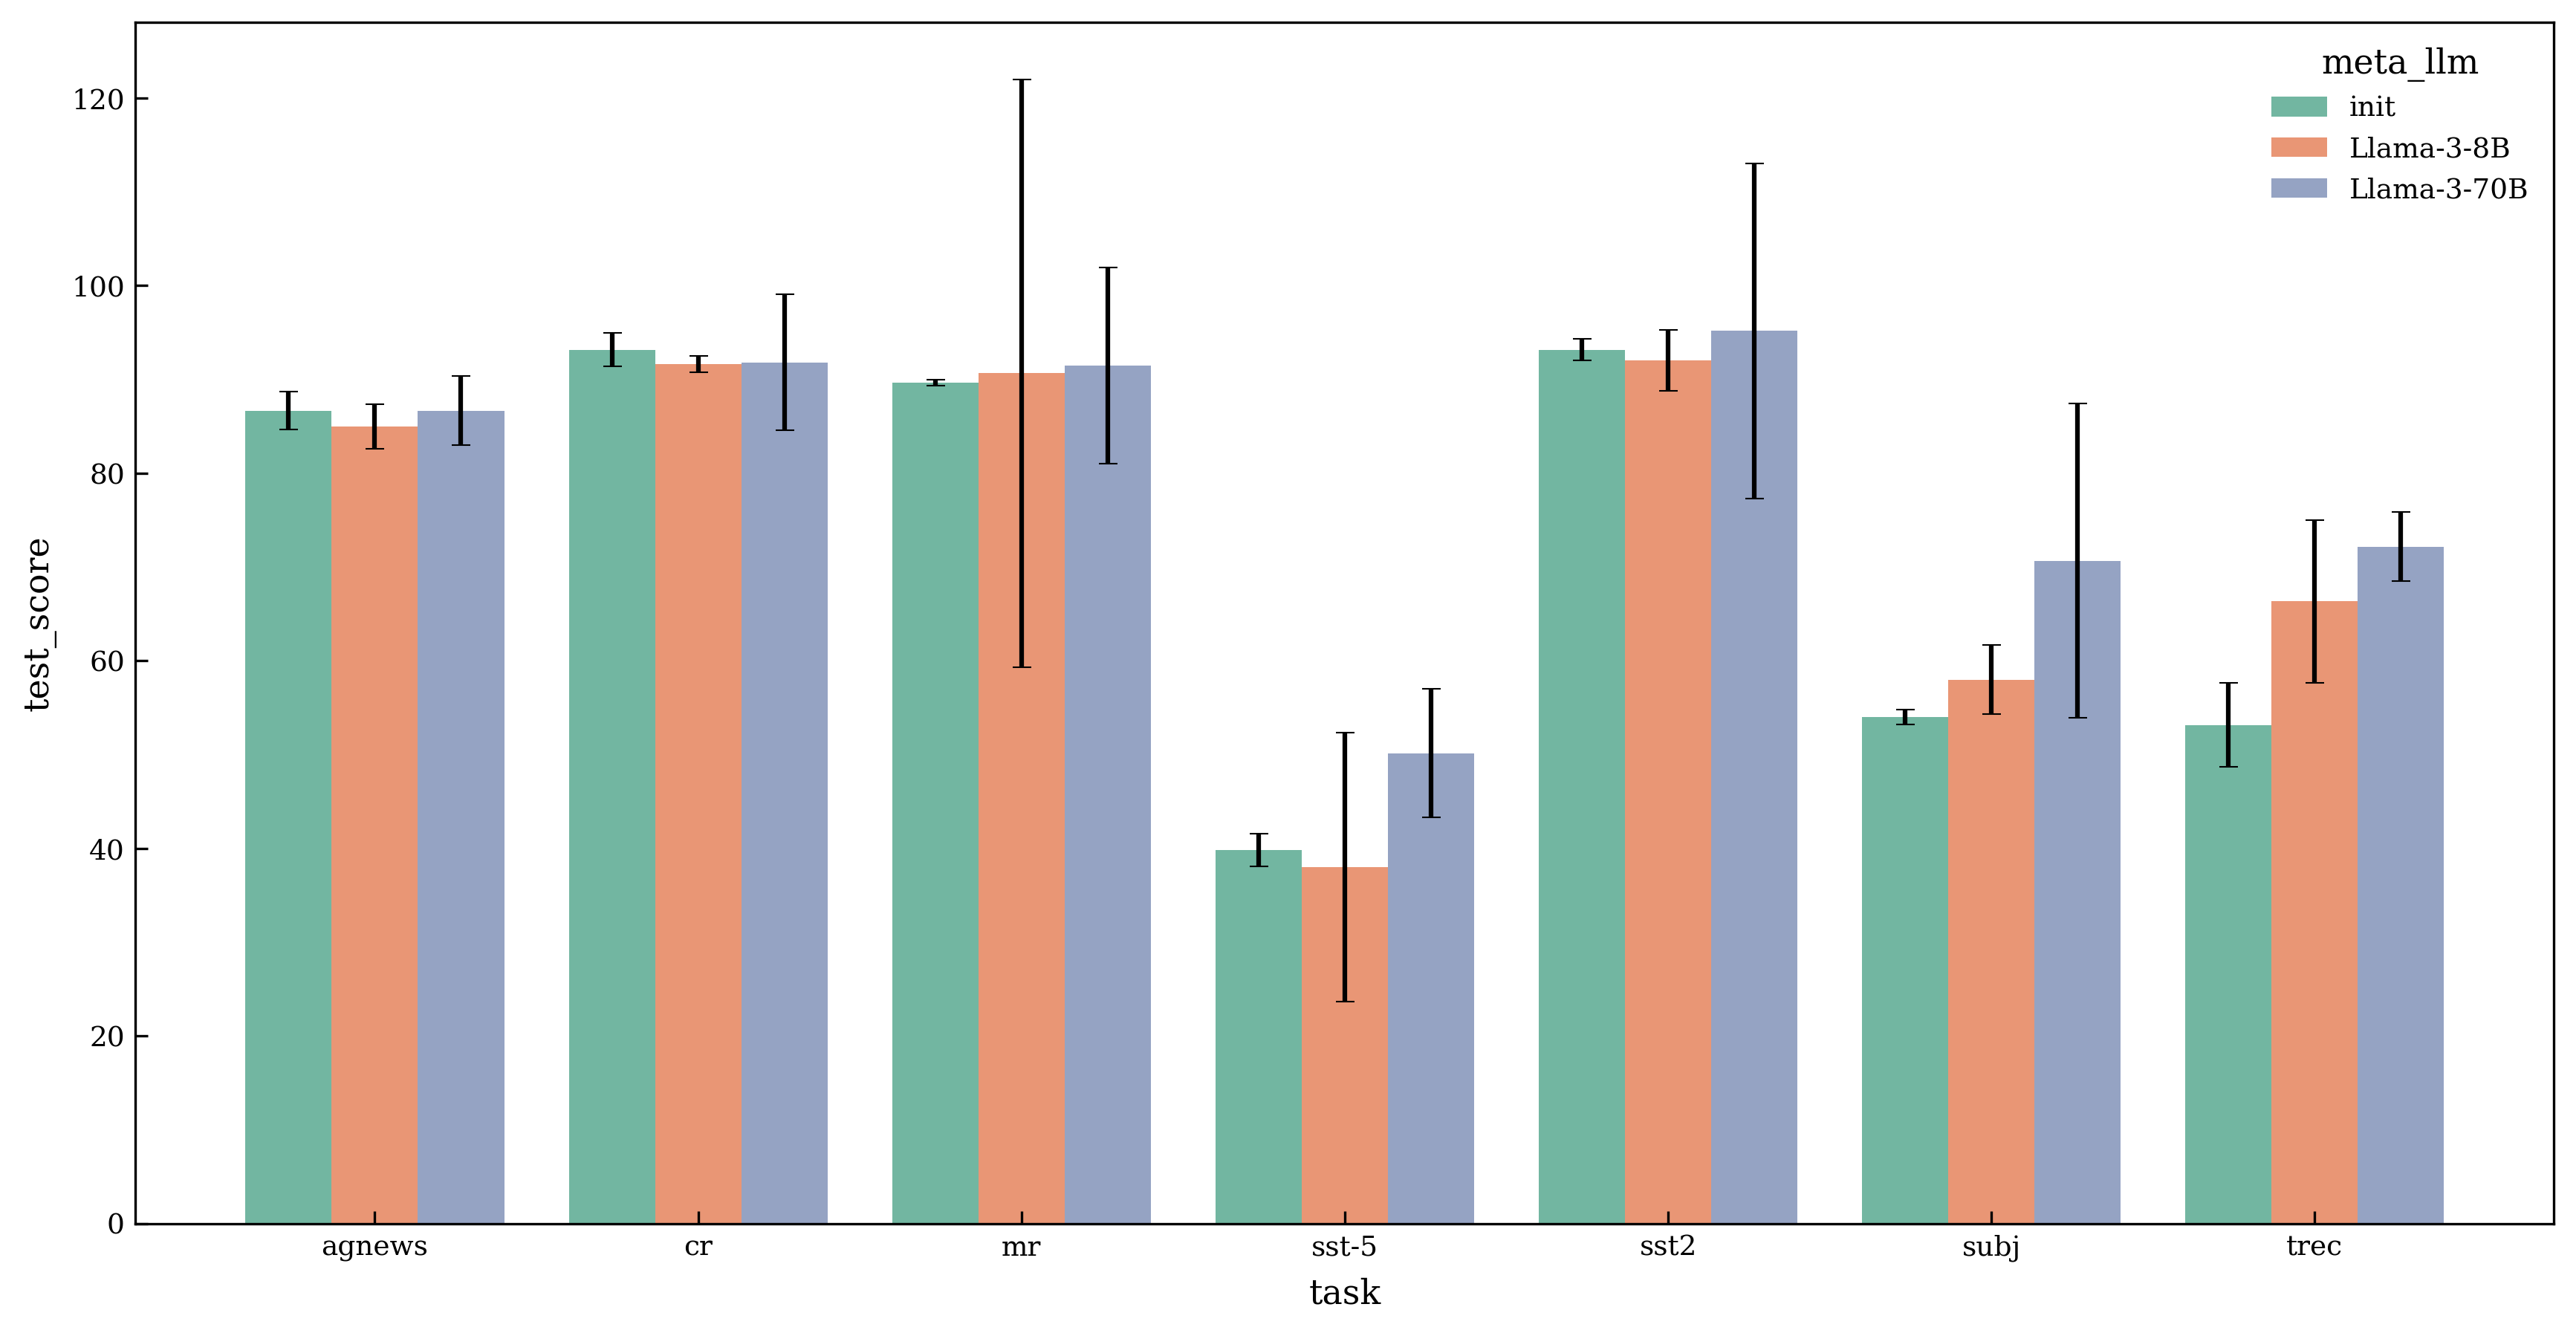

In [8]:
df_plot = best_scores_all[best_scores_all['optimizer'] == 'DE'].copy()
init_prompts = best_scores_all[(best_scores_all["optimizer"]=="init")]

df_plot = pd.concat([df_plot, init_prompts]).sort_values(by=["task", "meta_llm"], ascending=[True, False])

plot_bar(df_plot, "meta_llm", 'Comparison of 7B vs 30B for Each Task using DE')

In [24]:
df_plot

,task,optimizer,meta_llm,downstream_llm,use_task_desc,test_score,test_score_std
4,Average,init,init,Llama-3-70B,False,0.728095,NaN
1,Average,DE,Llama-3-8B,Llama-3-70B,False,0.745238,NaN
0,Average,DE,Llama-3-70B,Llama-3-70B,False,0.797381,NaN
0,agnews,init,init,Llama-3-70B,False,0.866667,0.020207
1,agnews,DE,Llama-3-8B,Llama-3-70B,False,0.850000,0.018028
0,agnews,DE,Llama-3-70B,Llama-3-70B,False,0.866667,0.002887
1,cr,init,init,Llama-3-70B,False,0.931667,0.017559
5,cr,DE,Llama-3-8B,Llama-3-70B,False,0.916667,0.011547
4,cr,DE,Llama-3-70B,Llama-3-70B,False,0.918333,0.007638
2,mr,init,init,Llama-3-70B,False,0.896667,0.044814


IndexError: single positional indexer is out-of-bounds

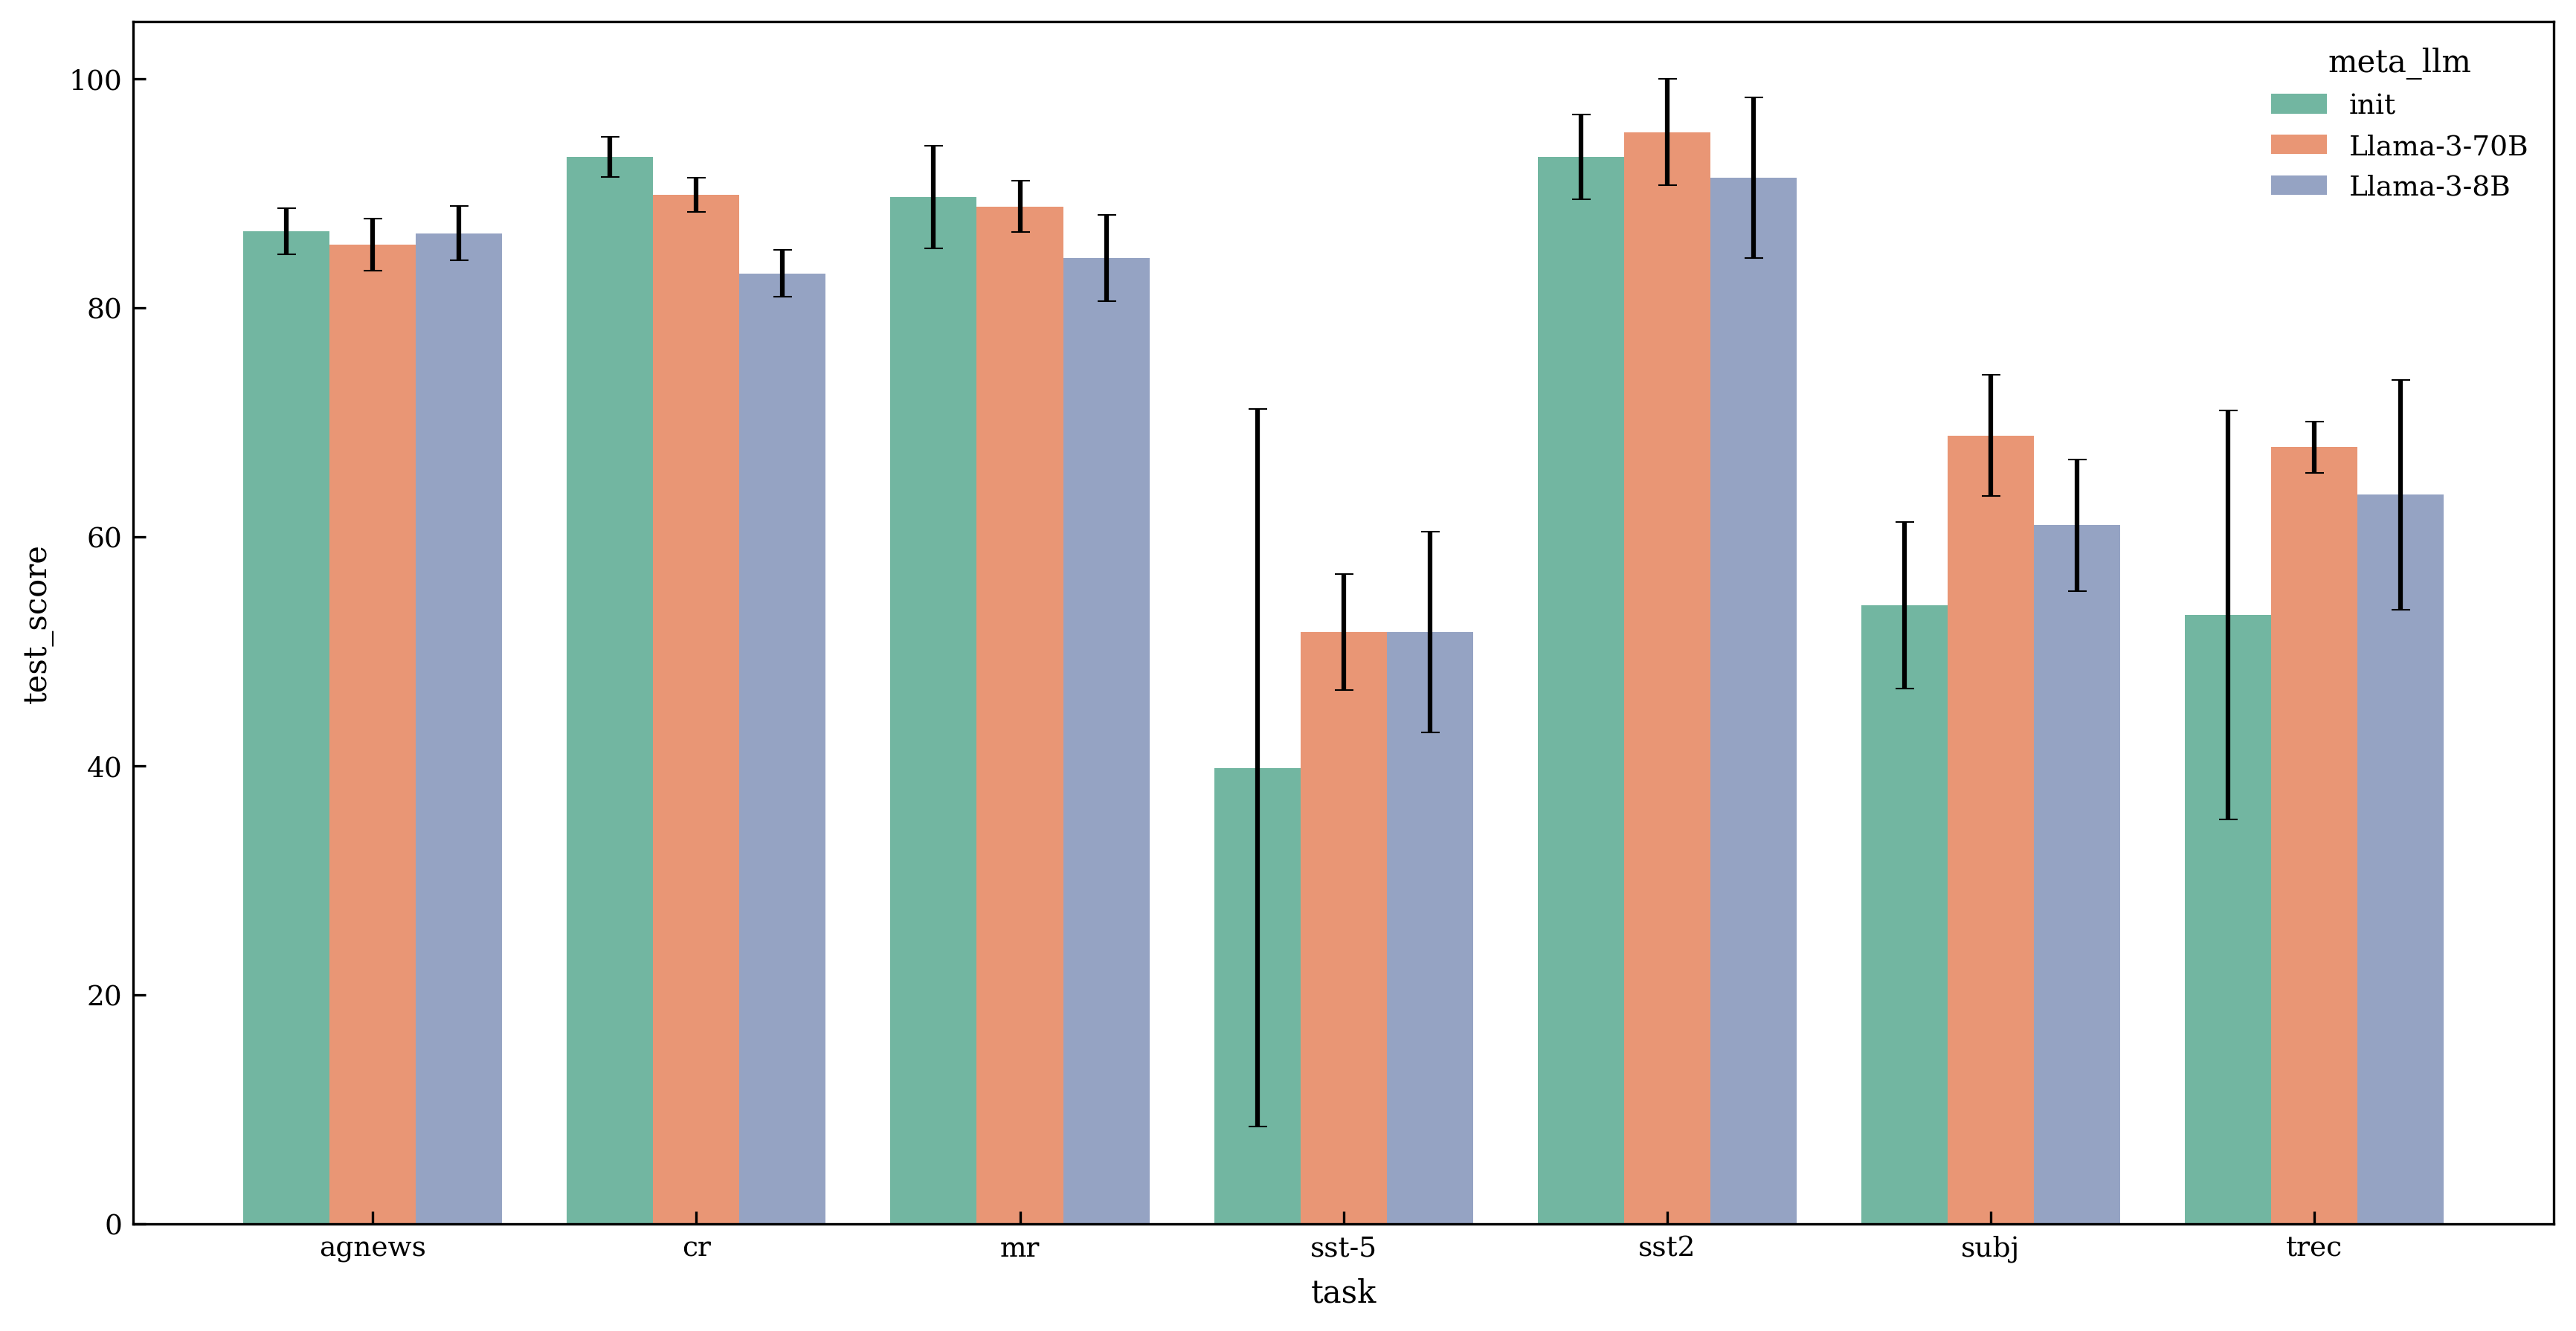

In [9]:
df_plot = best_scores_all[best_scores_all['optimizer'].isin(['GA', "init"])].copy()

plot_bar(df_plot,"meta_llm",  "Comparison of 7B vs 30B for each task using GA")

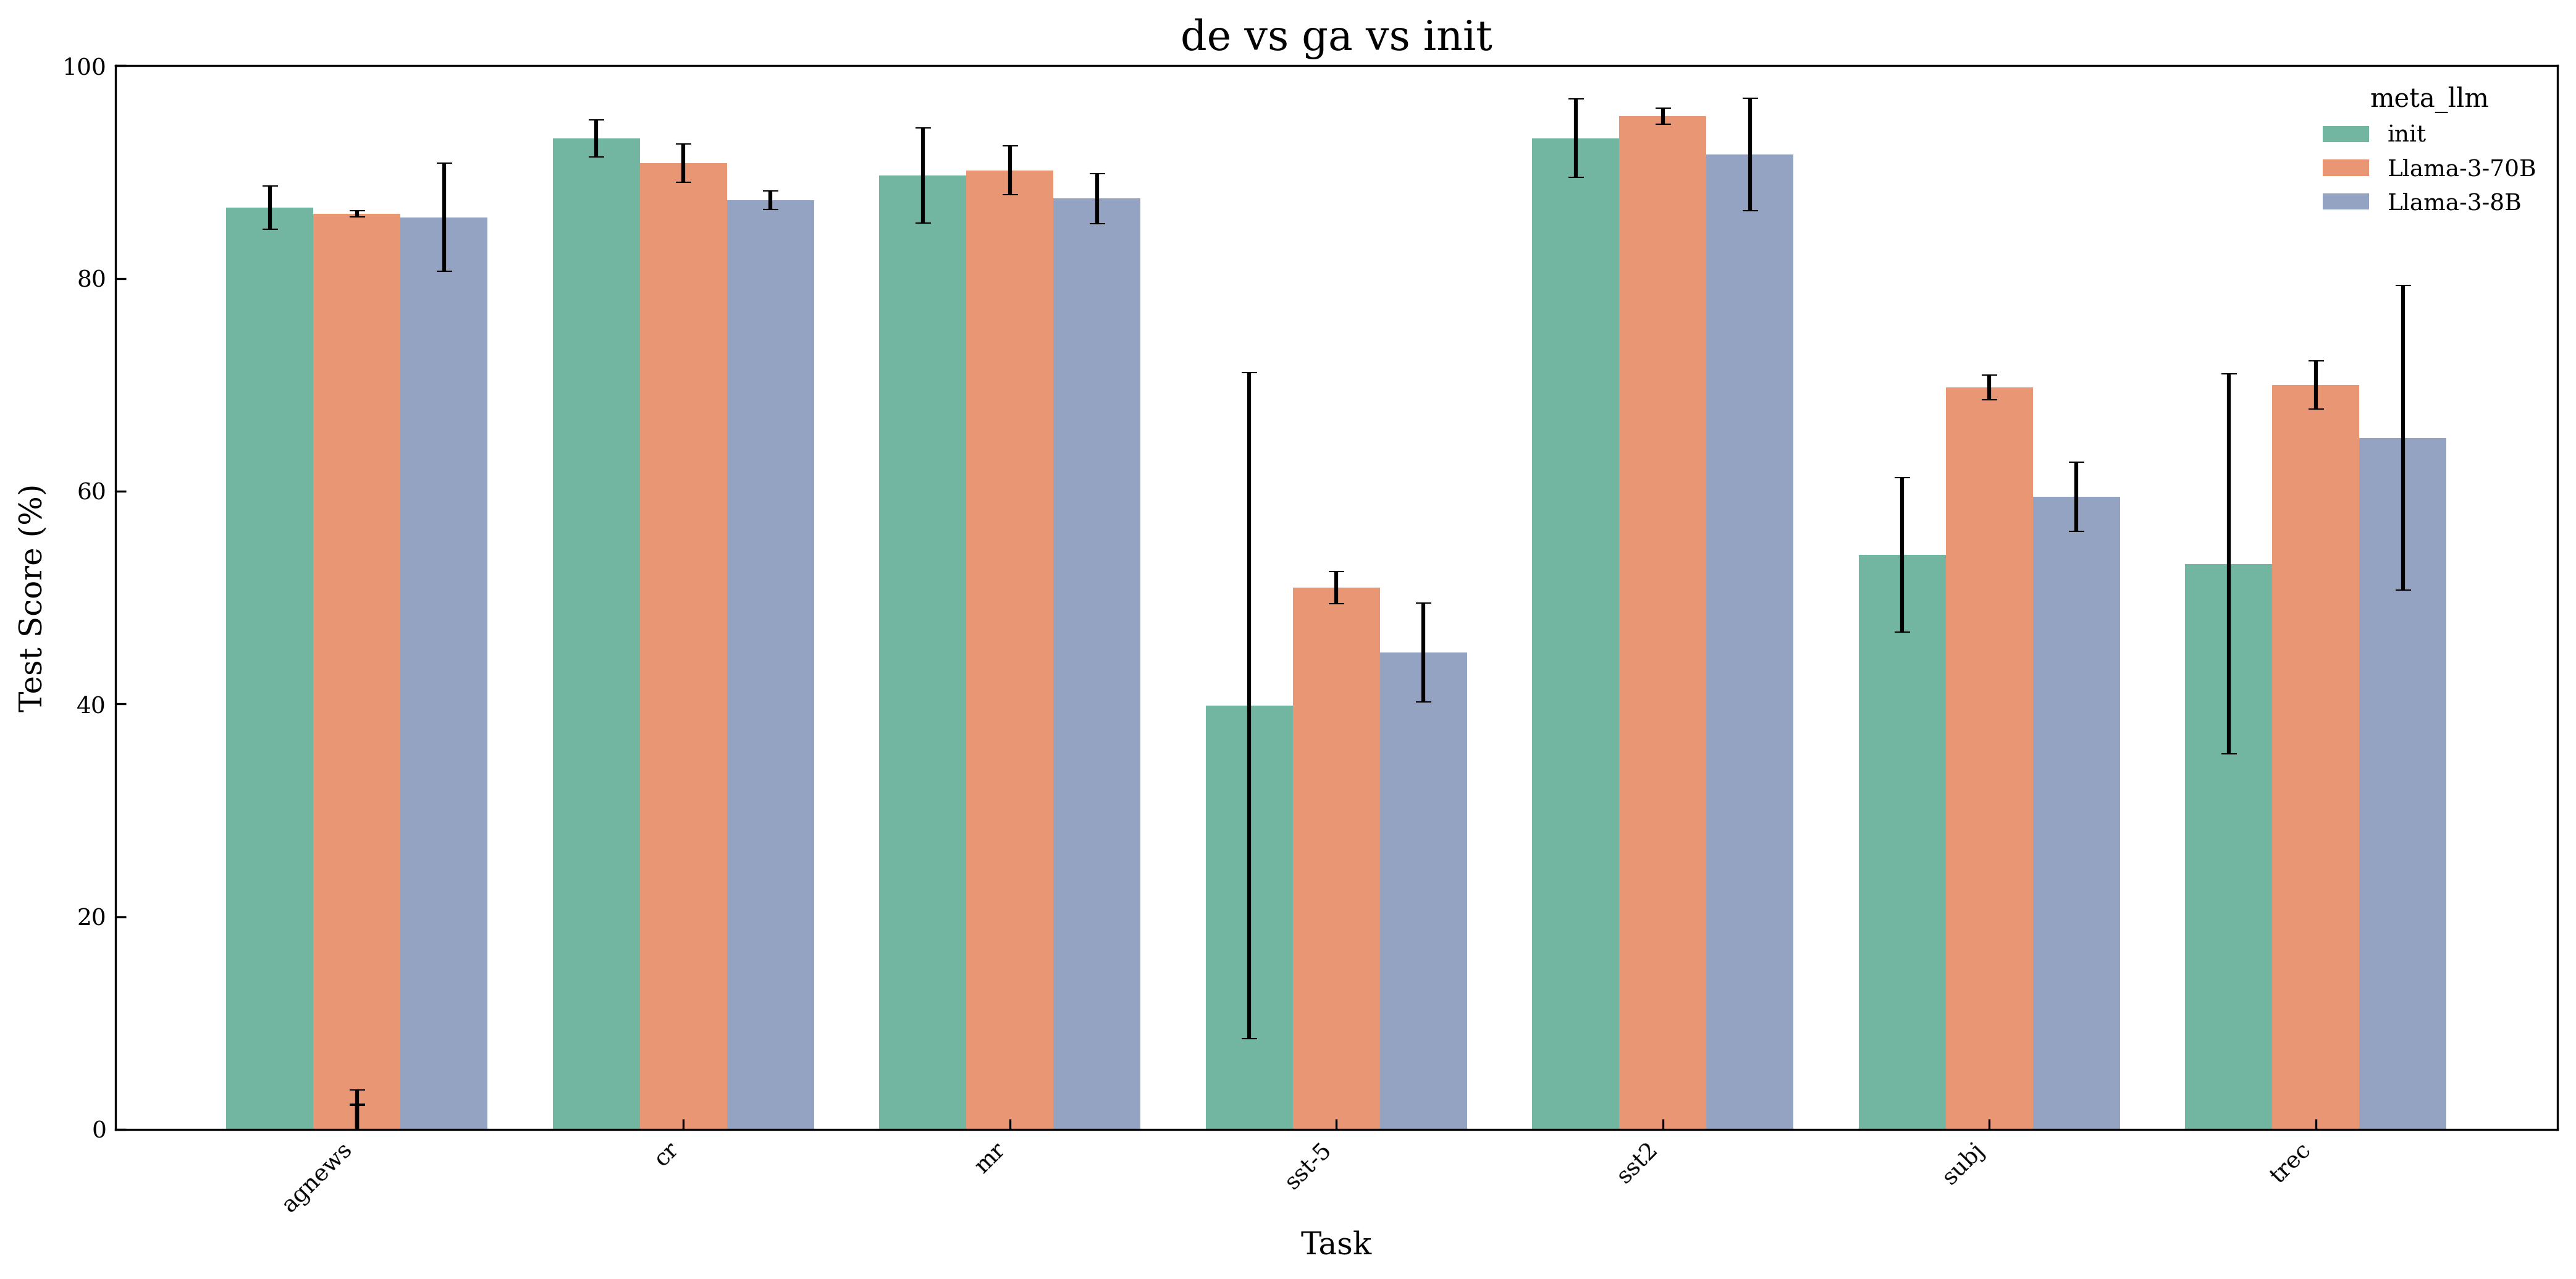

In [11]:
df_plot = best_scores_all[best_scores_all['downstream_llm'] == 'Llama-3-70B'].copy()

plot_bar(df_plot,"meta_llm",  "de vs ga vs init")

In [10]:
fancy_pants = format_score(best_scores_all)
get_result_table(fancy_pants)

task                                               Average        agnews  \
meta_llm    downstream_llm optimizer use_task_desc                         
Llama-3-70B Llama-3-70B    DE        False           79.74  86.67 ± 0.29   
                           GA        False           78.26  85.50 ± 2.29   
Llama-3-8B  Llama-3-70B    DE        False           74.52  85.00 ± 1.80   
                           GA        False           74.50  86.50 ± 1.50   
init        Llama-3-70B    init      False           72.81  86.67 ± 2.02   

task                                                          cr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.83 ± 0.76   
                           GA        False          89.83 ± 2.25   
Llama-3-8B  Llama-3-70B    DE        False          91.67 ± 1.15   
                           GA        False          83.00 ± 5.07   
init        Llama-3-70B    init      False          93.17 ± 1.76   

task                                                          mr  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          91.50 ± 0.87   
                           GA        False          88.83 ± 4.65   
Llama-3-8B  Llama-3-70B    DE        False          90.67 ± 2.36   
                           GA        False          84.33 ± 5.30   
init        Llama-3-70B    init      False          89.67 ± 4.48   

task                                                        sst-5  \
meta_llm    downstream_llm optimizer use_task_desc                  
Llama-3-70B Llama-3-70B    DE        False           50.17 ± 3.25   
                           GA        False           51.67 ± 2.25   
Llama-3-8B  Llama-3-70B    DE        False          38.00 ± 14.31   
                           GA        False           51.67 ± 2.36   
init        Llama-3-70B    init      False          39.83 ± 31.32   

task                                                        sst2  \
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False          95.17 ± 3.69   
                           GA        False          95.33 ± 2.02   
Llama-3-8B  Llama-3-70B    DE        False          92.00 ± 8.67   
                           GA        False          91.33 ± 3.79   
init        Llama-3-70B    init      False          93.17 ± 3.69   

task                                                         subj  \
meta_llm    downstream_llm optimizer use_task_desc                  
Llama-3-70B Llama-3-70B    DE        False           70.67 ± 6.83   
                           GA        False           68.83 ± 8.75   
Llama-3-8B  Llama-3-70B    DE        False          58.00 ± 10.44   
                           GA        False           61.00 ± 7.00   
init        Llama-3-70B    init      False           54.00 ± 7.26   

task                                                         trec  
meta_llm    downstream_llm optimizer use_task_desc                 
Llama-3-70B Llama-3-70B    DE        False           72.17 ± 3.69  
                           GA        False           67.83 ± 5.77  
Llama-3-8B  Llama-3-70B    DE        False          66.33 ± 16.74  
                           GA        False          63.67 ± 10.05  
init        Llama-3-70B    init      False          53.17 ± 17.86

## Results
- we can get worse than initial prompts in certain tasks
- variance of small model almost always higher

# Task Description

In [76]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison.meta_llm == "Llama-3-8B"]
df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

In [85]:
best_scores_td = read_best_scores("experiment-task-descr")
best_scores_td = get_mean_std(best_scores_td)
best_scores_td = get_avg_across_tasks(best_scores_td)
best_scores_td = clean_names(best_scores_td)

In [ ]:
df_plot = pd.concat([best_scores_td, df_comparison])
fancy_pants = format_score(df_plot)
get_result_table(fancy_pants)

In [ ]:
df_plot = pd.concat([best_scores_td, df_comparison])
df_plot = df_plot[df_plot.optimizer == "DE"]
plot_bar(df_plot, "use_task_desc", 'Usage of task_desc for Each Task using DE')

In [ ]:
df_plot = pd.concat([best_scores_td, df_comparison])
df_plot = df_plot[df_plot.optimizer == "GA"]
plot_bar(df_plot, "use_task_desc", 'Usage of task_desc for Each Task using GA')

# Different model families

In [48]:
df_experiment = read_best_scores("experiment_gpt")
df_experiment = df_experiment.drop("train_score", axis="columns")
df_experiment["use_task_desc"] = False
df_experiment = clean_names(df_experiment)
df_experiment = get_mean_std(df_experiment)
df_experiment = get_avg_across_tasks(df_experiment)

In [49]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["meta_llm"]=="Llama-3-70B"]
df_comparison = df_comparison[df_comparison["task"].isin(df_experiment.task.unique())]

df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

In [ ]:
df_plot = pd.concat([df_experiment, df_comparison])
plot_bar(df_plot, hue="downstream_llm")

In [ ]:
fancy_pants = format_score(df_plot)
get_result_table(fancy_pants)

# DE vs GA

In [ ]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["meta_llm"]=="Llama-3-70B"]

df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

plot_bar(df_comparison, hue="optimizer")

In [ ]:
fancy_pants = format_score(df_comparison)
get_result_table(fancy_pants)

In [ ]:
df_comparison = read_best_scores("experiment")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["meta_llm"]=="Llama-3-8B"]

df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

plot_bar(df_comparison, hue="optimizer")

In [ ]:
fancy_pants = format_score(df_comparison)
get_result_table(fancy_pants)

# GPT 4o vs initial prompts

In [52]:
df_comparison = read_best_scores("experiment-initial-prompts")
df_comparison[["meta_llm", "optimizer", "use_task_desc", "evaluation_llm"]] = "init"
df_comparison=df_comparison.drop("prompt", axis="columns")
df_comparison = clean_names(df_comparison)
df_comparison = df_comparison[df_comparison["downstream_llm"]=="gpt-4o"]
df_comparison = df_comparison[df_comparison["task"].isin(df_experiment.task.unique())]
df_comparison = get_mean_std(df_comparison)
df_comparison = get_avg_across_tasks(df_comparison)

In [ ]:
df_plot = pd.concat([df_experiment, df_comparison])
plot_bar(df_plot, hue="meta_llm")

In [ ]:
fancy_pants = format_score(df_plot)
get_result_table(fancy_pants)

# Results
- gpt-4o seems to be more sensitive to prompt than llama